# Gaussian Process training
This file just contains some stuff that I have done in order to get more familiar with the theory of Gaussian Kernels. All of what I do here is mostly based on the book "Gaussian Processes for Machine Learning" and [this website](https://docs.gpytorch.ai/en/stable/examples/00_Basic_Usage/Implementing_a_custom_Kernel.html).

In [184]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np
import scipy
import functools

from enum import Enum

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [185]:
class VariableType(Enum):
    cont = 1
    disc = 2
    
variable_types = [VariableType.cont]
kernel_params = [1]
cardinalities = {2: 5}

# NOTE: ALL OF THIS ASSUMES SCALAR INPUT, I.E., FLOATS OR INTS
def cont_base_kernel(x1, x2, ls=1.0):
    """
    The continuous base kernel of HyBO.
    As it is only used as a base kernel, it assumes the inputs to be scalars,
    
    Args:
        x1: First argument
        x2; Second argument
        ls: The lengthscale parameter (sigma in the paper)

    Returns:
        Evaluation of the kernel
    """
    sq_norm = np.abs(x1-x2)**2
    return 1/(2*np.pi*ls**2) * torch.exp(-0.5 / ls**2 * sq_norm)

def disc_base_kernel(x1, x2, card, beta=1):
    """
    The discrete base kernel of HyBO.
    It is only defined for a single dimension as we consider only base kernels here.
    x1 and x2 denote the input values and card is the cardinality of the set x1 and x2 belong to.
    This thus corresponds to eq. (4.8) of the HyBO paper for a single dimension, i.e., for m=1.
    """
    nominator = 1-np.exp(-card*beta)
    denominator = 1+(card-1)*np.exp(-card*beta)
    power = x1!=x2
    return(nominator/denominator)**power

def ith_base_kernel(x1, x2, i, hyperparameter=1):
    """
    The ith base kernel.
    It check whether the ith variable is discrete or continuous and returns the corresponding function evaluation.
    """
    variable_type = variable_types[i]
    if variable_type == VariableType.cont:
        return cont_base_kernel(x1,x2, hyperparameter)
    else:
        return disc_base_kernel(x1, x2, cardinalities[i], hyperparameter)

@functools.lru_cache(maxsize=128)
def power_sum(kernel_inputs, j, kernel_params):
    """
    Calculate the j-the power sum of the kernels with respect to a list of inputs.
    The i-th entry of kernels is the i-the kernel.
    kernel_inputs is the input to the kernels.
    j denotes the power to which every kernel should be taken.
    This caclulation corresponds to the calculation of the S_j given in eq. 4.11. of the HyBO paper.
    """
    num_of_var = len(kernel_params)
    return sum(ith_base_kernel(*kernel_inputs, i, kernel_params[i])**j for i in range(num_of_var))


@functools.lru_cache(maxsize=128)
def pth_kernel(x1, x2, p, kernel_params, theta_p_list):
    """Does not implement the theta_p values yet.
    Probably extremely inefficient."""
    # Recursion base
    if p==0:
        return theta_p_list[0]**2*1
    total_sum = 0
    # Need to iterate backwards here as only then the recursion works correctly
    for j in range(p,0,-1):
        factor = (-1)**(j-1)
        kernel = pth_kernel(x1,x2,p-j, kernel_params, theta_p_list)
        p_sum = power_sum((x1,x2),j,kernel_params)
        total_sum += factor*kernel*p_sum
    return theta_p_list[p-1]**2*total_sum                          
    #return 1/p*sum((-1)**(j-1)*pth_kernel(x1,x2,p-j)*power_sum((x1,x2),j,kernel_params) for j in range(1,p))
    
def hybrid_kernel(x1, x2, kernel_params, theta_p_list):
    num_of_vars = len(kernel_params)
    return sum(pth_kernel(x1,x2,p, kernel_params, theta_p_list) for p in range(1,num_of_vars+1))

In [186]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

# Wrap training, prediction and plotting from the ExactGP-Tutorial into a function,
# so that we do not have to repeat the code later on
def train(model, likelihood, training_iter=training_iter):
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()


def predict(model, likelihood, test_x = torch.linspace(0, 1, 51)):
    model.eval()
    likelihood.eval()
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Test points are regularly spaced along [0,1]
        return likelihood(model(test_x))

def plot(observed_pred, test_x=torch.linspace(0, 1, 51)):
    with torch.no_grad():
        # Initialize plot
        f, ax = plt.subplots(1, 1, figsize=(4, 3))

        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
        # Plot training data as black stars
        ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [187]:
class SincKernel(gpytorch.kernels.Kernel):
    # the sinc kernel is stationary
    is_stationary = True

    # We will register the parameter when initializing the kernel
    def __init__(self, length_prior=None, length_constraint=None, theta_p_prior=None, theta_p_constraint=None, **kwargs):
        super().__init__(**kwargs)

        # register the raw parameter
        self.register_parameter(
            name='raw_length', parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )
        
        # register the raw parameter
        self.register_parameter(
            name='raw_theta', parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )

        # set the parameter constraint to be positive, when nothing is specified
        if length_constraint is None:
            length_constraint = Positive()
        if theta_p_constraint is None:
            theta_p_constraint = Positive()

        # register the constraint
        self.register_constraint("raw_length", length_constraint)
        self.register_constraint("raw_theta", theta_p_constraint)

        # set the parameter prior, see
        # https://docs.gpytorch.ai/en/latest/module.html#gpytorch.Module.register_prior
        if length_prior is not None:
            self.register_prior(
                "length_prior",
                length_prior,
                lambda m: m.length,
                lambda m, v : m._set_length(v),
            )
        if theta_p_prior is not None:
            self.register_prior(
                "theta_prior",
                theta_p_prior,
                lambda m: m.length,
                lambda m, v : m._set_theta(v),
            )

    # now set up the 'actual' paramter
    @property
    def length(self):
        # when accessing the parameter, apply the constraint transform
        return self.raw_length_constraint.transform(self.raw_length)
    
    @property
    def theta(self):
        # when accessing the parameter, apply the constraint transform
        return self.raw_theta_constraint.transform(self.raw_theta)

    @length.setter
    def length(self, value):
        return self._set_length(value)
    
    @length.setter
    def theta(self, value):
        return self._set_theta(value)

    def _set_length(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_length)
        # when setting the paramater, transform the actual value to a raw one by applying the inverse transform
        self.initialize(raw_length=self.raw_length_constraint.inverse_transform(value))
        
    def _set_theta(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_theta)
        # when setting the paramater, transform the actual value to a raw one by applying the inverse transform
        self.initialize(raw_theta=self.raw_theta_constraint.inverse_transform(value))

    # this is the kernel function
    def forward(self, x1, x2, **params):
        num_of_vars = x1.shape[1]
        full_covar = torch.zeros(x1.shape[0], x2.shape[0])
        for i, x1_point in enumerate(x1):
            for j, x2_point in enumerate(x2):
                theta_p_list = tuple([1])
                cov = hybrid_kernel(x1_point,x2_point, self.length, self.theta)
                full_covar[i,j] = cov
        return full_covar

tensor([[0.3492]], grad_fn=<SoftplusBackward0>)
tensor([[0.3492]], grad_fn=<SoftplusBackward0>)


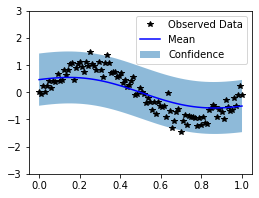

In [189]:
from gpytorch.constraints import Positive

training_iter = 30

# Use the simplest form of GP model, exact inference
class SincGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = SincKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize the new model
model = SincGPModel(train_x, train_y, likelihood)

# set to training mode and train
model.train()
likelihood.train()
train(model, likelihood)

# Get into evaluation (predictive posterior) mode and predict
model.eval()
likelihood.eval()
observed_pred = predict(model, likelihood)
# plot results
plot(observed_pred)
print(model.covar_module.length)
print(model.covar_module.theta)